In [27]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler



%matplotlib inline

In [28]:
df = pd.read_csv('train_taxi.csv', nrows = 10000)

In [29]:
print(df.head())

                             key  fare_amount          pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3       

Text(0.5,0,'Hours')

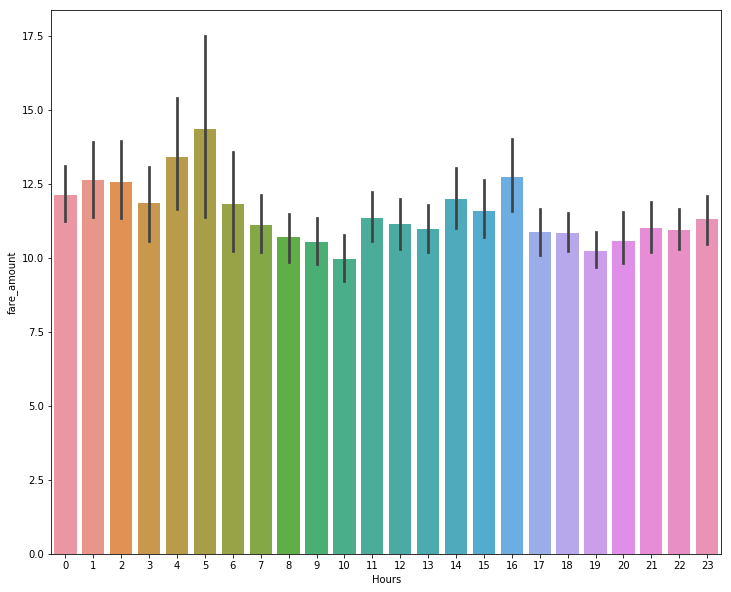

In [30]:
#Let's create new features based on 'pickup_datetime' column, we can split values by day, month, year and etc.
#Firstly, convert 'pickup_datetime' to datetime format

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")

#Add new columns:
df['Weekday'] = df['pickup_datetime'].dt.weekday
df['Hour'] = df['pickup_datetime'].dt.hour
df['Month'] = df['pickup_datetime'].dt.month
df['Year'] = df['pickup_datetime'].dt.year
df['Day'] = df['pickup_datetime'].dt.day


#Let's check how particular hour, day and weekday affected taxi fares. I assume that pick hours(morning and 6-7 pm) might be more than
#normal hours, as well as wekends might cause hight taxi rates:
_ = plt.figure(figsize=(12,10))
_ = sns.barplot('Hour','fare_amount', data=df)
plt.xlabel('Hours')

Text(0.5,0,'Day')

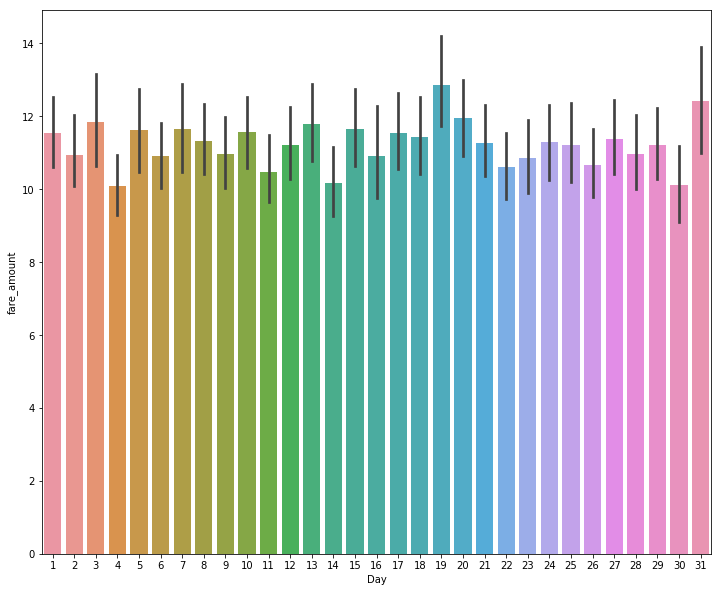

In [31]:
_ = plt.figure(figsize=(12,10))
_ = sns.barplot('Day','fare_amount', data=df)
plt.xlabel('Day')

Text(0.5,0,'Weekday')

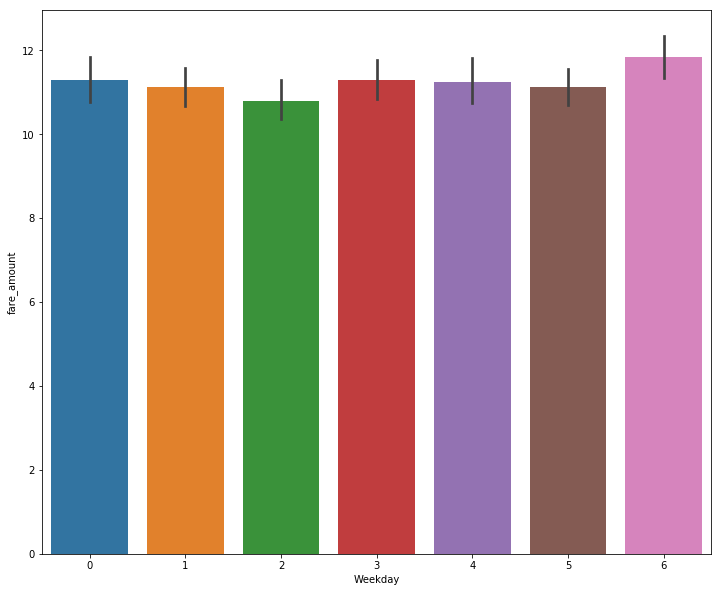

In [32]:
_ = plt.figure(figsize=(12,10))
_ = sns.barplot('Weekday','fare_amount', data=df)
plt.xlabel('Weekday')

In [33]:
#We can see any sagnificant differences in taxi fares by hour, day, or weekday. 

In [34]:
#Define distance between pickup and dripoff points:
def distance(lat1, lat2, lon1, lon2):
    R = 6373.0
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R*c

df['Dist'] = distance(df['pickup_latitude'], df['dropoff_latitude'], df['pickup_longitude'], 
                                         df['dropoff_longitude'])


In [35]:
#Drop 'key' and 'pickup_datetime' columns as they're not necessary for thr further data analysis
df.drop(['key', 'pickup_datetime'], 1, inplace=True)

print(df.head())

#Add features  with distances to public places in NY, such as : John Kennedy Airport,Newark Liberty International Airport,
#LaGuardia Airport and Central Park, to define how different areas of NY city afeected taxi fares.
def dist_to_public_place(dataset):

    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    cpark_coord = (40.785091, -73.968285)
    
    dataset['jfk_dr'] = distance(dataset['dropoff_latitude'], jfk_coord[0],dataset['dropoff_longitude'],jfk_coord[1] ) 
#     dataset['jfk_pi'] = distance(dataset['pickup_latitude'], jfk_coord[0],dataset['pickup_longitude'],jfk_coord[1] )  

    dataset['ewr_dr'] = distance(dataset['dropoff_latitude'], ewr_coord[0],dataset['dropoff_longitude'],ewr_coord[1] ) 
#     dataset['ewr_pi'] = distance(dataset['pickup_latitude'], ewr_coord[0],dataset['pickup_longitude'],ewr_coord[1] )  

    dataset['lga_dr'] = distance(dataset['dropoff_latitude'], lga_coord[0],dataset['dropoff_longitude'],lga_coord[1] ) 
#     dataset['lga_pi'] = distance(dataset['pickup_latitude'], lga_coord[0],dataset['pickup_longitude'],lga_coord[1] )  

    dataset['cpark_dr'] = distance(dataset['dropoff_latitude'], cpark_coord[0],dataset['dropoff_longitude'],cpark_coord[1] ) 
#     dataset['cpark_pi'] = distance(dataset['pickup_latitude'], cpark_coord[0],dataset['pickup_longitude'],cpark_coord[1] )  



    return dataset

df = dist_to_public_place(df)
print(df.head())



   fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          4.5        -73.844311        40.721319         -73.841610   
1         16.9        -74.016048        40.711303         -73.979268   
2          5.7        -73.982738        40.761270         -73.991242   
3          7.7        -73.987130        40.733143         -73.991567   
4          5.3        -73.968095        40.768008         -73.956655   

   dropoff_latitude  passenger_count  Weekday  Hour  Month  Year  Day  \
0         40.712278                1        0    17      6  2009   15   
1         40.782004                1        1    16      1  2010    5   
2         40.750562                2        3     0      8  2011   18   
3         40.758092                1        5     4      4  2012   21   
4         40.783762                1        1     7      3  2010    9   

       Dist  
0  1.031088  
1  8.452786  
2  1.389961  
3  2.800149  
4  1.999784  
   fare_amount  pickup_longitude  pickup_lat

In [36]:
#Let's check our dataset for outliers and clean them.
print(df.describe())


        fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  10000.000000      10000.000000     10000.000000       10000.000000   
mean      11.235464        -72.466660        39.920448         -72.474094   
std        9.584258         10.609729         7.318932          10.579732   
min       -2.900000        -74.438233       -74.006893         -74.429332   
25%        6.000000        -73.992058        40.734547         -73.991112   
50%        8.500000        -73.981758        40.752693         -73.980083   
75%       12.500000        -73.966925        40.767694         -73.963504   
max      180.000000         40.766125       401.083332          40.802437   

       dropoff_latitude  passenger_count       Weekday          Hour  \
count      10000.000000     10000.000000  10000.000000  10000.000000   
mean          39.893281         1.644700      3.025100     13.506000   
std            6.339919         1.271229      1.972627      6.516089   
min          -73.9

In [37]:
#After exploring final features for some extreme values, there're some outliers noticed in 'fare amount'(some negative values) and in 
#'passenger count'(zero values) and in pickup and dropoff points as well.
def cleaning_df(df):
    return df[(df.fare_amount > 0) & 
            (df.pickup_longitude > -80) & (df.pickup_longitude < -70) &
            (df.pickup_latitude > 35) & (df.pickup_latitude < 45) &
            (df.dropoff_longitude > -80) & (df.dropoff_longitude < -70) &
            (df.dropoff_latitude > 35) & (df.dropoff_latitude < 45) &
             (df.passenger_count > 0) & (df.passenger_count < 10)]

df = cleaning_df(df)
print(df.describe())


       fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  9753.000000       9753.000000      9753.000000        9753.000000   
mean     11.240946        -73.974720        40.751260         -73.973941   
std       9.525694          0.042828         0.038284           0.039249   
min       0.010000        -74.438233        39.616075         -74.429332   
25%       6.000000        -73.992253        40.736140         -73.991278   
50%       8.500000        -73.982092        40.753450         -73.980510   
75%      12.500000        -73.968282        40.768085         -73.965388   
max     180.000000        -73.137393        41.366138         -73.137393   

       dropoff_latitude  passenger_count      Weekday         Hour  \
count       9753.000000      9753.000000  9753.000000  9753.000000   
mean          40.751889         1.652517     3.022762    13.516662   
std            0.039414         1.270419     1.973807     6.499712   
min           39.604972         1.0

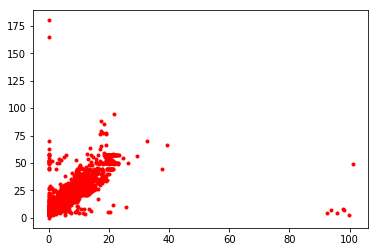

Dist                 0.697016
cpark_dr             0.340428
pickup_longitude     0.315782
dropoff_longitude    0.260279
ewr_dr               0.229456
jfk_dr               0.189205
pickup_latitude      0.138477
dropoff_latitude     0.116866
Year                 0.099579
lga_dr               0.098715
Month                0.041055
Hour                 0.034117
passenger_count      0.014378
Weekday              0.014287
Day                  0.002260
Name: fare_amount, dtype: float64


In [45]:
_ = plt.plot(df['Dist'], df['fare_amount'], marker='.', linestyle='none', color='red')
plt.show()

#Let's see the correleation between fare amount and all the features
max_corr = df.corr().abs()['fare_amount'].sort_values(ascending=False)[1:]
print(max_corr)



In [46]:
#First model - simple Linear Regression
y = df['fare_amount']
X = df.drop('fare_amount', axis = 1)

X = X.loc[:, max_corr.index]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.25, random_state=42)

pip = Pipeline(steps = 
        [("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression())])

pip.fit(X_train, y_train)
print('Model score', pip.score(X_test, y_test))
print('RMSE', np.sqrt(mean_squared_error(y_test, pip.predict(X_test))))

#RMSE - the main metric in the competition shows not the best possible result, so lwt's try XGBoosting model

0.5886713446984373 0.5886713446984486
RMSE 6.090682378668113 6.090682378668029


In [47]:
#First let's implement GridSearch method for defining the best prameters for our model:

# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }
# xg_reg = xgb.XGBRegressor(parobjective ='reg:linear', learning_rate = 0.5, n_estimators = 100)


# xg_search = GridSearchCV(xg_reg, params)
# xg_search.fit(X_train,y_train)

# print(xg_search.best_score_)
# print(xg_search.best_params_)

# Output:
# 0.7484887397858683
# {'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}


#After selecting best parameters, let's train our model:
xg_reg = xgb.XGBRegressor(parobjective ='reg:linear', learning_rate = 0.09, n_estimators = 100,
                         colsample_bytree = 1, gamma = 1.5, max_depth = 3,
                         min_child_weight = 1, subsample =1)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
print(xg_reg.score(X_test, y_test))

RMSE: 3.915437
0.8300123181655821
